# PyTorch Tutorial

## CLMR

In the following examples, we will be taking a look at how Contrastive Learning of Musical Representations (Spijkervet & Burgoyne, 2021) uses self-supervised learning to learn powerful representations for the downstream task of music classification. 

<div align="center">
<img width="700" src="../../../../book/images/janne/clmr_model.png"/>
</div>

In the above figure, we transform a single audio example into two, distinct augmented views by processing it through a set of stochastic audio augmentations.

In [13]:
import torch
from argparse import Namespace
from tqdm import tqdm

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"We are using the following the device to train: {device}")

# initialize an empty argparse Namespace in which we can store argumens for training
args = Namespace()


args.audio_length = 59049 # every piece of audio has a length of 59049 samples
args.sample_rate = 22050 # the sample rate of our audio

We are using the following the device to train: cpu


In [14]:
import os
import random
import torch
import numpy as np
import soundfile as sf
from torch.utils import data
from torchaudio_augmentations import (
    RandomResizedCrop,
    RandomApply,
    PolarityInversion,
    Noise,
    Gain,
    HighLowPass,
    Delay,
    PitchShift,
    Reverb,
    Compose,
)


GTZAN_GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


class GTZANDataset(data.Dataset):
    def __init__(self, data_path, split, num_samples, num_chunks, is_augmentation):
        self.data_path =  data_path if data_path else ''
        self.split = split
        self.num_samples = num_samples
        self.num_chunks = num_chunks
        self.is_augmentation = is_augmentation
        self.genres = GTZAN_GENRES
        self._get_song_list()
        if is_augmentation:
            self._get_augmentations()

    def _get_song_list(self):
        list_filename = os.path.join(self.data_path, '%s_filtered.txt' % self.split)
        with open(list_filename) as f:
            lines = f.readlines()
        self.song_list = [line.strip() for line in lines]

    def _get_augmentations(self):
        transforms = [
            RandomResizedCrop(n_samples=self.num_samples),
            RandomApply([PolarityInversion()], p=0.8),
            RandomApply([Noise(min_snr=0.3, max_snr=0.5)], p=0.3),
            RandomApply([Gain()], p=0.2),
            RandomApply([HighLowPass(sample_rate=22050)], p=0.8),
            RandomApply([Delay(sample_rate=22050)], p=0.5),
            RandomApply([PitchShift(n_samples=self.num_samples, sample_rate=22050)], p=0.4),
            RandomApply([Reverb(sample_rate=22050)], p=0.3),
        ]
        self.augmentation = Compose(transforms=transforms)

    def _adjust_audio_length(self, wav):
        if self.split == 'train':
            random_index = random.randint(0, len(wav) - self.num_samples - 1)
            wav = wav[random_index : random_index + self.num_samples]
        else:
            hop = (len(wav) - self.num_samples) // self.num_chunks
            wav = np.array([wav[i * hop : i * hop + self.num_samples] for i in range(self.num_chunks)])
        return wav
    
    def get_augmentation(self, wav):
        return self.augmentation(torch.from_numpy(wav).unsqueeze(0)).squeeze(0).numpy()
    
    def __getitem__(self, index):
        line = self.song_list[index]

        # get genre
        genre_name = line.split('/')[0]
        genre_index = self.genres.index(genre_name)

        # get audio
        audio_filename = os.path.join(self.data_path, 'genres', line)
        wav, fs = sf.read(audio_filename)

        # adjust audio length
        wav = self._adjust_audio_length(wav).astype('float32')

        # data augmentation
        if self.is_augmentation:
            wav_i = self.get_augmentation(wav)
            wav_j = self.get_augmentation(wav)
        else:
            wav_i = wav
            wav_j = wav
            
        return (wav_i, wav_j), genre_index

    def __len__(self):
        return len(self.song_list)

def get_dataloader(data_path=None, 
                   split='train', 
                   num_samples=22050 * 29, 
                   num_chunks=1, 
                   batch_size=16, 
                   num_workers=0, 
                   is_augmentation=False):
    is_shuffle = True if (split == 'train') else False
    batch_size = batch_size if (split == 'train') else (batch_size // num_chunks)
    data_loader = data.DataLoader(dataset=GTZANDataset(data_path, 
                                                       split, 
                                                       num_samples, 
                                                       num_chunks, 
                                                       is_augmentation),
                                  batch_size=batch_size,
                                  shuffle=is_shuffle,
                                  drop_last=False,
                                  num_workers=num_workers)
    return data_loader


In [15]:
args.batch_size = 48


train_loader = get_dataloader(data_path="../../codes/split", split='train', is_augmentation=True, num_samples=59049, batch_size=args.batch_size)
iter_train_loader = iter(train_loader)
(train_wav_i, _), train_genre = next(iter_train_loader)

valid_loader = get_dataloader(data_path="../../codes/split", split='valid', num_samples=args.audio_length, batch_size=args.batch_size)
test_loader = get_dataloader(data_path="../../codes/split", split='test', num_samples=args.audio_length, batch_size=args.batch_size)
iter_test_loader = iter(test_loader)
(test_wav_i, _), test_genre = next(iter_test_loader)
print('training data shape: %s' % str(train_wav_i.shape))
print('validation/test data shape: %s' % str(test_wav_i.shape))
print(train_genre)

training data shape: torch.Size([48, 59049])
validation/test data shape: torch.Size([48, 1, 59049])
tensor([3, 4, 8, 0, 9, 4, 3, 0, 2, 2, 1, 8, 6, 1, 5, 7, 3, 4, 5, 3, 4, 0, 8, 0,
        9, 3, 0, 5, 9, 6, 7, 1, 1, 3, 2, 1, 1, 9, 0, 1, 6, 5, 8, 1, 4, 3, 9, 8])



### Audio Data Augmentations
Now, let's apply a series of transformations, each applied with an independent probability:
- Crop
- Filter
- Reverb
- Polarity
- Noise
- Pitch
- Gain
- Delay


In [16]:
import torchaudio
from torchaudio_augmentations import (
    RandomApply,
    ComposeMany,
    RandomResizedCrop,
    PolarityInversion,
    Noise,
    Gain,
    HighLowPass,
    Delay,
    PitchShift,
    Reverb,
)

In [18]:
args.transforms_polarity = 0.8
args.transforms_filters = 0.6
args.transforms_noise = 0.1
args.transforms_gain = 0.3
args.transforms_delay = 0.4
args.transforms_pitch = 0.4
args.transforms_reverb = 0.4



train_transform = [
    RandomResizedCrop(n_samples=args.audio_length),
    RandomApply([PolarityInversion()], p=args.transforms_polarity),
    RandomApply([Noise()], p=args.transforms_noise),
    RandomApply([Gain()], p=args.transforms_gain),
    RandomApply([HighLowPass(sample_rate=args.sample_rate)], p=args.transforms_filters),
    RandomApply([Delay(sample_rate=args.sample_rate)], p=args.transforms_delay),
    RandomApply([PitchShift(n_samples=args.audio_length, sample_rate=args.sample_rate)], p=args.transforms_pitch),
    RandomApply([Reverb(sample_rate=args.sample_rate)], p=args.transforms_reverb),
]
train_loader.augmentation = Compose(train_transform)

Remember, always take a moment to listen to the data that you will give to your model!
Let's listen to three examples from our dataset, on which a series of stochastic audio data augmentations are applied:

In [19]:
from IPython.display import Audio

for idx in range(3):
    print(f"Iteration: {idx}")
    (x_i, x_j), y = train_loader.dataset[0]
    
    print("Positive pair: (x_i, x_j):")
    display(Audio(x_i, rate=args.sample_rate))
    display(Audio(x_j, rate=args.sample_rate))
    

Iteration: 0
Positive pair: (x_i, x_j):


Iteration: 1
Positive pair: (x_i, x_j):


Iteration: 2
Positive pair: (x_i, x_j):


<div style="margin: auto; width: 700px;">
    <img src="../../../../book/images/janne/clmr_local_overview.png"/>
</div>


## SampleCNN Encoder
First, let us begin with initializing our feature extractor.
In CLMR, we chose the SampleCNN encoder to learn high-level features from raw pieces of audio. In the above figure, this encoder is denoted as $g_{enc}$. The last fully connected layer will be removed, so that we obtain an expressive final vector on which we can compute our contrastive loss.

In [21]:
import torch.nn as nn

class SampleCNN(nn.Module):
    def __init__(self, strides, supervised, out_dim):
        super(SampleCNN, self).__init__()

        self.strides = strides
        self.supervised = supervised
        self.sequential = [
            nn.Sequential(
                nn.Conv1d(1, 128, kernel_size=3, stride=3, padding=0),
                nn.BatchNorm1d(128),
                nn.ReLU(),
            )
        ]

        self.hidden = [
            [128, 128],
            [128, 128],
            [128, 256],
            [256, 256],
            [256, 256],
            [256, 256],
            [256, 256],
            [256, 256],
            [256, 512],
        ]

        assert len(self.hidden) == len(
            self.strides
        ), "Number of hidden layers and strides are not equal"
        for stride, (h_in, h_out) in zip(self.strides, self.hidden):
            self.sequential.append(
                nn.Sequential(
                    nn.Conv1d(h_in, h_out, kernel_size=stride, stride=1, padding=1),
                    nn.BatchNorm1d(h_out),
                    nn.ReLU(),
                    nn.MaxPool1d(stride, stride=stride),
                )
            )

        # 1 x 512
        self.sequential.append(
            nn.Sequential(
                nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm1d(512),
                nn.ReLU(),
            )
        )

        self.sequential = nn.Sequential(*self.sequential)

        if self.supervised:
            self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, out_dim)
    
    def initialize(self, m):
        if isinstance(m, (nn.Conv1d)):
            nn.init.kaiming_uniform_(m.weight, mode="fan_in", nonlinearity="relu")
            
    def forward(self, x):
        x = x.unsqueeze(dim=1) # here, we add a dimension for our convolution.
        out = self.sequential(x)
        if self.supervised:
            out = self.dropout(out)

        out = out.reshape(x.shape[0], out.size(1) * out.size(2))
        logit = self.fc(out)
        return logit

In [23]:
# in the GTZAN dataset, we have 10 genre labels
args.n_classes = 10

encoder = SampleCNN(
    strides=[3, 3, 3, 3, 3, 3, 3, 3, 3],
    supervised=False,
    out_dim=args.n_classes,
).to(device)
print(encoder)

SampleCNN(
  (sequential): Sequential(
    (0): Sequential(
      (0): Conv1d(1, 128, kernel_size=(3,), stride=(3,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_s

## SimCLR

Since we removed the last fully connected layer, we are left with a $512$-dimensional feature vector. We would like to use this vector in our contrastive learning task. Therefore, we wrap our encoder in the objective as introduced by SimCLR: we project the final hidden layer of the encoder to a different latent space using a small MLP projector network. In the `forward` pass, we extract both the final hidden representation of our `SampleCNN` encoder (`h_i` and `h_j`), and the projected vectors (`z_i` and `z_j`).

In [25]:
class SimCLR(nn.Module):

    def __init__(self, encoder, projection_dim, n_features):
        super(SimCLR, self).__init__()

        self.encoder = encoder
        self.n_features = n_features

        # Replace the fc layer with an Identity function
        self.encoder.fc = Identity()

        # We use a MLP with one hidden layer to obtain z_i = g(h_i) = W(2)σ(W(1)h_i) where σ is a ReLU non-linearity.
        self.projector = nn.Sequential(
            nn.Linear(self.n_features, self.n_features, bias=False),
            nn.ReLU(),
            nn.Linear(self.n_features, projection_dim, bias=False),
        )

    def forward(self, x_i, x_j):        
        h_i = self.encoder(x_i)
        h_j = self.encoder(x_j)

        z_i = self.projector(h_i)
        z_j = self.projector(h_j)
        return h_i, h_j, z_i, z_j
    

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

## Loss

Here, we apply an InfoNCE loss, as proposed by van den Oord et al. (2018) for contrastive learning. InfoNCE loss compares the similarity of our representations $z_i$ and $z_j$, to the similarity of $z_i$ to any other representation in our batch, and applies a softmax over the obtained similarity values. We can write this loss more formally as follows:

$$\ell_{i, j}=-\log \frac{\exp \left(\operatorname{sim}\left(z_{i}, z_{j}\right) / \tau\right)}{\sum_{k=1}^{2 N} \mathbb{1}_{[k \neq i]} \exp \left(\operatorname{sim}\left(z_{i}, z_{k}\right) / \tau\right)}
$$


The similarity metric is the cosine similarity between our representations:

$$\operatorname{sim}\left(z_{i}, z_{j}\right)=\frac{z_{i}^{\top} \cdot z_{j}}{\left\|z_{i}\right\| \cdot\left\|z_{j}\right\|}$$

<div style="margin: auto; width: 800px">
    <img src="../../../../book/images/janne/nt_xent_loss_nominator.png"/>
</div>

```
z = torch.cat((z_i, z_j), dim=0)`
```

```
sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature
```

```
sim_i_j = torch.diag(sim, self.batch_size * self.world_size)
sim_j_i = torch.diag(sim, -self.batch_size * self.world_size)
```

```
positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
```

```
negative_samples = sim[self.mask].reshape(N, -1)
```

<div style="margin: auto; width: 400px;">
    <img src="../../../../book/images/janne/nt_xent_loss_denominator.png"/>
</div>



In [26]:
import torch
import torch.nn as nn

class NT_Xent(nn.Module):
    def __init__(self, batch_size, temperature, world_size):
        super(NT_Xent, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.world_size = world_size

        self.mask = self.mask_correlated_samples(batch_size, world_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size, world_size):
        N = 2 * batch_size * world_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        for i in range(batch_size * world_size):
            mask[i, batch_size * world_size + i] = 0
            mask[batch_size * world_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):
        """
        We do not sample negative examples explicitly.
        Instead, given a positive pair, similar to (Chen et al., 2017), we treat the other 2(N − 1) augmented examples within a minibatch as negative examples.
        """
        N = 2 * self.batch_size * self.world_size

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        sim_i_j = torch.diag(sim, self.batch_size * self.world_size)
        sim_j_i = torch.diag(sim, -self.batch_size * self.world_size)

        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)

        labels = torch.zeros(N).to(positive_samples.device).long()
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        return loss

## Pre-training CLMR


<div style="margin: auto; width: 800px">
    <img src="../../../../book/images/janne/clmr_loss_animation.gif"/>
</div>


```{note}
The following code will pre-train our SampleCNN encoder using our contrastive loss.
This needs to run on a machine with a GPU to accelerate training, otherwise it will take a very long time.
```

In [16]:
args.temperature = 0.5 # the temperature scaling parameter in our NT-Xent los


encoder = SampleCNN(
    strides=[3, 3, 3, 3, 3, 3, 3, 3, 3],
    supervised=False,
    out_dim=0,
).to(device)


# get dimensions of last fully-connected layer
n_features = (
    encoder.fc.in_features
)  
print(f"Dimension of our h_i, h_j vectors: {n_features}")

model = SimCLR(encoder, projection_dim=64, n_features=n_features).to(device)

temperature = 0.5
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = NT_Xent(args.batch_size, args.temperature, world_size=1)

epochs = 100
losses = []

for e in range(epochs):
    
    for (x_i, x_j), y in train_loader:
        optimizer.zero_grad()
        
        x_i = x_i.to(device)
        x_j = x_j.to(device)
        
        # here, we extract the latent representations, and the projected vectors,
        # from the positive pairs:
        h_i, h_j, z_i, z_j = model(x_i, x_j)
        
        # here, we calculate the NT-Xent loss on the projected vectors:
        loss = criterion(z_i, z_j)
        
        # backpropagation:
        loss.backward()
        optimizer.step()
    
        print(f"Loss: {loss}")
        losses.append(loss.detach().item())
        
        break # we are only running a single pass for demonstration purposes.
        
    print(f"Mean loss: {np.array(losses).mean()}")
    break # we are only running a single epoch for demonstration purposes.

Dimension of our h_i, h_j vectors: 512
Loss: 2.5802388191223145
Mean loss: 2.5802388191223145


## Linear Evaluation
Now, we would like to evaluate the versatility of our learned representations.
We will train a linear classifier on the representations extracted from our pre-trained SampleCNN encoder.


<div style="margin: auto; width: 800px;">
    <img src="../../../../book/images/janne/clmr_global_overview.png"/>
</div>


```{warning}
Note that we will not be using data augmentations during linear evaluation.
```

In [28]:
args.batch_size = 16


train_loader = get_dataloader(data_path="../../codes/split", split='train', is_augmentation=False, num_samples=args.audio_length, batch_size=args.batch_size)
valid_loader = get_dataloader(data_path="../../codes/split", split='valid', num_samples=args.audio_length, batch_size=args.batch_size)
test_loader = get_dataloader(data_path="../../codes/split", split='test', num_samples=args.audio_length, batch_size=args.batch_size)

iter_train_loader = iter(train_loader)
iter_test_loader = iter(test_loader)


for idx in range(3):
    (train_wav, _), train_genre = train_loader.dataset[idx]
    display(Audio(train_wav, rate=args.sample_rate))

Our linear classifier has a single hidden layer and a softmax output (which is already included in the `torch.nn.CrossEntropy` loss function, hence we omit it here).

In [29]:
class LinearModel(nn.Module):

    def __init__(self, hidden_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.model = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, x):
        return self.model(x)

In [19]:
def train_linear_model(encoder, linear_model, epochs, learning_rate):

    # we now use a regular CrossEntropy loss to compare our predicted genre labels with the ground truth labels.
    criterion = nn.CrossEntropyLoss()

    # the Adam optimizer is used here as our optimization algorithm
    optimizer = torch.optim.Adam(
        linear_model.parameters(),
        lr=learning_rate,
    )

    losses = []
    for e in range(epochs):
        epoch_losses = []
        for (x, _), y in tqdm(train_loader):

            optimizer.zero_grad()

            # we will not be backpropagating the gradients of the SampleCNN encoder:
            with torch.no_grad():
                h = encoder(x)

            p = linear_model(h)

            loss = criterion(p, y)

            loss.backward()
            optimizer.step()


            # print(f"Loss: {loss}")
            epoch_losses.append(loss.detach().item())
        
        mean_loss = np.array(epoch_losses).mean()
        losses.append(mean_loss)
        print(f"Epoch: {e}\tMean loss: {mean_loss}")
    return losses

In [20]:
args.linear_learning_rate = 1e-4
args.linear_epochs = 15
print(f"We will train for {args.linear_epochs} epochs during linear evaluation")


# First, we freeze SampleCNN encoder weights
encoder.eval()
for param in encoder.parameters():
    param.requires_grad = False

print(f"Dimension of the last layer of our SampleCNN feature extractor network: {n_features}")


# initialize our linear model, with dimensions:
# n_features x n_classes

linear_model = LinearModel(n_features, args.n_classes)
print(linear_model)

losses = train_linear_model(encoder, linear_model, epochs=args.linear_epochs, learning_rate=args.linear_learning_rate)

We will train for 15 epochs during linear evaluation
Dimension of the last layer of our SampleCNN feature extractor network: 512
LinearModel(
  (model): Linear(in_features=512, out_features=10, bias=True)
)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:37<00:00,  1.33s/it]


Epoch: 0	Mean loss: 2.3029658624104092


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:37<00:00,  1.33s/it]


Epoch: 1	Mean loss: 2.3026398164885387


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:37<00:00,  1.34s/it]


Epoch: 2	Mean loss: 2.302783123084477


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:37<00:00,  1.34s/it]


Epoch: 3	Mean loss: 2.302727324622018


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:37<00:00,  1.34s/it]


Epoch: 4	Mean loss: 2.302577691418784


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:37<00:00,  1.34s/it]


Epoch: 5	Mean loss: 2.3024674568857466


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:37<00:00,  1.34s/it]


Epoch: 6	Mean loss: 2.3024762954030717


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:37<00:00,  1.35s/it]


Epoch: 7	Mean loss: 2.302462100982666


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:38<00:00,  1.36s/it]


Epoch: 8	Mean loss: 2.302406898566655


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:38<00:00,  1.36s/it]


Epoch: 9	Mean loss: 2.3019944769995555


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:38<00:00,  1.36s/it]


Epoch: 10	Mean loss: 2.302449566977365


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:38<00:00,  1.36s/it]


Epoch: 11	Mean loss: 2.3020790219306946


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:38<00:00,  1.36s/it]


Epoch: 12	Mean loss: 2.301789471081325


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:38<00:00,  1.36s/it]


Epoch: 13	Mean loss: 2.302112783704485


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:38<00:00,  1.36s/it]

Epoch: 14	Mean loss: 2.3021752067974637


In the `evaluate` function, we perform a full pass of the test dataset and extract the predictions from our linear classifier, given the representations of our pre-trained encoder.

In [40]:
# Run evaluation

def evaluate(encoder, linear_model=None, test_loader=None):
    encoder.eval()
    if linear_model is not None:
        linear_model.eval()
    
    y_true = []
    y_pred = []

    with torch.no_grad():
        for (wav, _), genre_index in tqdm(test_loader):
            wav = wav.to(device)
            genre_index = genre_index.to(device)

            # reshape and aggregate chunk-level predictions
            b, c, t = wav.size()
            
            with torch.no_grad():
                if linear_model is None:
                    logits = encoder(wav.squeeze(1))
                else:
                    h = encoder(wav.squeeze(1))
                    logits = linear_model(h)

            logits = logits.view(b, c, -1).mean(dim=1)
            _, pred = torch.max(logits.data, 1)

            # append labels and predictions
            y_true.extend(genre_index.tolist())
            y_pred.extend(pred.tolist())
            
    return y_true, y_pred

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:26<00:00,  1.39s/it]


Accuracy: 0.1069


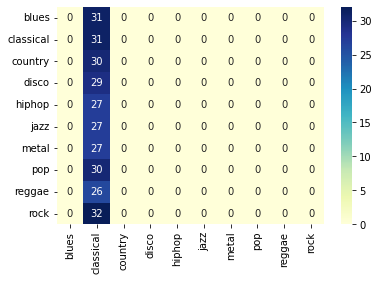

In [22]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix


y_true, y_pred = evaluate(encoder, linear_model, test_loader)

accuracy = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, xticklabels=GTZAN_GENRES, yticklabels=GTZAN_GENRES, cmap='YlGnBu')
print('Accuracy: %.4f' % accuracy)

We can also load the weights of a fully pre-trained CLMR model to our `SampleCNN` encoder. The pre-trained representations will hopefully be more expressive for the linear classifier to solve the problem of music classification.

```{note}

Pre-training the encoder takes a while to complete, so let's load the pre-trained weights into our encoder now to speed this up:
```

In [23]:
from collections import OrderedDict
pre_trained_weights = torch.load("./clmr_pretrained.ckpt", map_location=device)

# this dictionary contains a few parameters we do not need  in this tutorial, so we discard them here:
pre_trained_weights = OrderedDict({k.replace("encoder.", ""): v for k, v in pre_trained_weights.items() if "encoder" in k})


# let's load the weights into our encoder:
encoder = SampleCNN(
    strides=[3, 3, 3, 3, 3, 3, 3, 3, 3],
    supervised=False,
    out_dim=0,
).to(device)
encoder.fc = Identity()
encoder.load_state_dict(pre_trained_weights)
encoder.eval()

# we re-initialize our linear model here to discard the previously learned parameters.
linear_model = LinearModel(n_features, args.n_classes)
losses_with_clmr = train_linear_model(encoder, linear_model, epochs=args.linear_epochs, learning_rate=args.linear_learning_rate)

/Users/janne/miniconda3/envs/tutorial/lib/python3.8/site-packages/torch/nn/init.py:388: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:38<00:00,  1.38s/it]


Epoch: 0	Mean loss: 2.340274861880711


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:38<00:00,  1.36s/it]


Epoch: 1	Mean loss: 2.1566108635493686


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:38<00:00,  1.36s/it]


Epoch: 2	Mean loss: 2.0396491161414554


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:38<00:00,  1.37s/it]


Epoch: 3	Mean loss: 1.948716210467475


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:38<00:00,  1.36s/it]


Epoch: 4	Mean loss: 1.871069073677063


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:38<00:00,  1.37s/it]


Epoch: 5	Mean loss: 1.7560220999377114


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:38<00:00,  1.37s/it]


Epoch: 6	Mean loss: 1.6884811690875463


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:38<00:00,  1.36s/it]


Epoch: 7	Mean loss: 1.6221486585480827


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:38<00:00,  1.36s/it]


Epoch: 8	Mean loss: 1.5455367820603507


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:38<00:00,  1.37s/it]


Epoch: 9	Mean loss: 1.4933379547936576


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:38<00:00,  1.36s/it]


Epoch: 10	Mean loss: 1.4579386711120605


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:38<00:00,  1.37s/it]


Epoch: 11	Mean loss: 1.3922432788780756


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:38<00:00,  1.37s/it]


Epoch: 12	Mean loss: 1.3564506087984358


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:38<00:00,  1.37s/it]


Epoch: 13	Mean loss: 1.3168576232024602


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:38<00:00,  1.37s/it]

Epoch: 14	Mean loss: 1.270722210407257


### Get ROC-AUC and PR-AUC scores on test set

Let's now compute the accuracy of a *linear* classifier, trained on the representations from a pre-trained CLMR model.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:25<00:00,  1.33s/it]


Accuracy: 0.5517


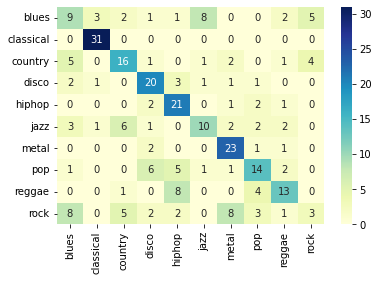

In [24]:
y_true_pretrained, y_pred_pretrained = evaluate(encoder, linear_model, test_loader)

pretrained_accuracy = accuracy_score(y_true_pretrained, y_pred_pretrained)
cm = confusion_matrix(y_true_pretrained, y_pred_pretrained)
sns.heatmap(cm, annot=True, xticklabels=GTZAN_GENRES, yticklabels=GTZAN_GENRES, cmap='YlGnBu')
print('Accuracy: %.4f' % pretrained_accuracy)

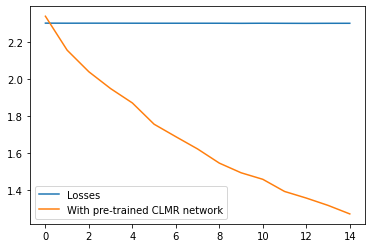

In [25]:
import matplotlib.pyplot as plt

plt.plot(losses, label="Losses")
plt.plot(losses_with_clmr, label="With pre-trained CLMR network")
plt.legend()
plt.show()

## How does a supervised SampleCNN model compare?

In [33]:
# let's load the weights into our encoder:
supervised_samplecnn = SampleCNN(
    strides=[3, 3, 3, 3, 3, 3, 3, 3, 3],
    supervised=True,
    out_dim=args.n_classes,
).to(device)

optimizer = torch.optim.Adam(supervised_samplecnn.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

epochs = 15
losses = []
for e in range(epochs):
    epoch_losses = []
    for (x, _), y in tqdm(train_loader):
        optimizer.zero_grad()
        logits = supervised_samplecnn(x)
        
        # here, we calculate the NT-Xent loss on the projected vectors:
        loss = criterion(logits, y)
        
        # backpropagation:
        loss.backward()
        optimizer.step()
    
        # print(f"Loss: {loss}")
        epoch_losses.append(loss.detach().item())
        
    mean_loss = np.array(epoch_losses).mean()
    losses.append(mean_loss)
    print(f"Epoch: {e}\tMean loss: {mean_loss}")
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [01:59<00:00,  4.25s/it]


Epoch: 0	Mean loss: 2.0514306170599803


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [01:59<00:00,  4.26s/it]


Epoch: 1	Mean loss: 1.777217332805906


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [02:00<00:00,  4.29s/it]


Epoch: 2	Mean loss: 1.6308889814785548


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [02:00<00:00,  4.29s/it]


Epoch: 3	Mean loss: 1.508283602339881


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [02:02<00:00,  4.38s/it]


Epoch: 4	Mean loss: 1.4906416535377502


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [01:57<00:00,  4.20s/it]


Epoch: 5	Mean loss: 1.4243347091334206


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [02:00<00:00,  4.31s/it]


Epoch: 6	Mean loss: 1.3204487540892191


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [01:56<00:00,  4.16s/it]


Epoch: 7	Mean loss: 1.2581013866833277


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [01:56<00:00,  4.15s/it]


Epoch: 8	Mean loss: 1.3584619547639574


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [01:56<00:00,  4.16s/it]


Epoch: 9	Mean loss: 1.2448890315634864


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [01:56<00:00,  4.16s/it]


Epoch: 10	Mean loss: 1.2725025245121546


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [01:57<00:00,  4.18s/it]


Epoch: 11	Mean loss: 1.2021435052156448


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [01:57<00:00,  4.19s/it]


Epoch: 12	Mean loss: 1.159744279725211


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [01:57<00:00,  4.19s/it]


Epoch: 13	Mean loss: 1.1804143616131373


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [01:58<00:00,  4.24s/it]

Epoch: 14	Mean loss: 1.0627801907914025


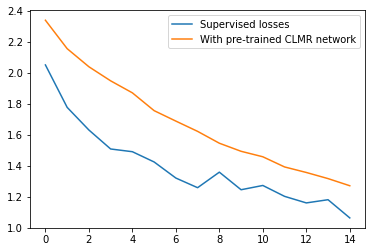

In [44]:
plt.plot(losses, label="Supervised losses")
plt.plot(losses_with_clmr, label="With pre-trained CLMR network")
plt.legend()
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:26<00:00,  1.41s/it]


Accuracy: 0.4966


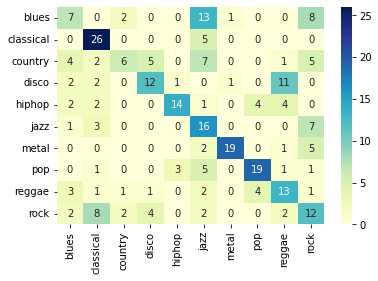

In [42]:
y_true_supervised, y_pred_supervised = evaluate(supervised_samplecnn, linear_model=None, test_loader=test_loader)

supervised_accuracy = accuracy_score(y_true_supervised, y_pred_supervised)
cm = confusion_matrix(y_true_supervised, y_pred_supervised)
sns.heatmap(cm, annot=True, xticklabels=GTZAN_GENRES, yticklabels=GTZAN_GENRES, cmap='YlGnBu')
print('Accuracy: %.4f' % supervised_accuracy)

## Conclusion

In conclusion, we observed how a self-supervised model, that pre-trains its network by way of leveraging the underlying structure of the data, can learn strong representations for the downstream task of music classification.

We have:
1. Pre-trained a SampleCNN encoder with CLMR.
2. Evaluated the representations with a linear classifier.
3. Loaded pre-trained weights from CLMR trained on the MagnaTagATune dataset.
4. Trained a linear classifier on these representations.

Our final accuracy when training the linear classifier for 15 epochs is ~**55.2%** on the downstream task of music classification on the GTZAN dataset.

It is important compare against an equivalent network that is trained in a supervised manner.
Therefore, we also trained a supervised SampleCNN model from scratch, which reached an accuracy of ~**49.6%**.

|Model|Accuracy|
|---|---|
|Supervised SampleCNN | 49.6%|
|Self-supervised CLMR + SampleCNN | 55.2%|

```note
Note that in these experiments, the supervised model may have well overfitted on the GTZAN training data. This tutorial is by no means an exhaustive search for an optimal set of model and training parameters.
```

In conclusion, it is exciting to see that a linear classifier reaches a comparable performance, compared to a fully optimized encoder, using representations that were learned in a task-agnostic manner by way of self-supervised learning.